- 브레인 튜머 : https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD, Adam
import matplotlib .pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet

# Project-1

- Goal : ImageDataGenerator와 TL을 이용해서 오버피팅이 최소가 될 수 있도록 90%이상의 정확도 달성
- 오버피팅이 심하고 90%이상의 성능이 나오지 않는다면, 문제점과 해결 방안을 찾아본다.

###  경로설정

In [2]:
root_dir = "content"
data_root_dir = os.path.join(root_dir, "brain_tumor")
train_data_root_dir = os.path.join(data_root_dir, "Training")
test_data_root_dir = os.path.join(data_root_dir, "Testing")

### 데이터셋 가져오기

In [ ]:
### Colab 실행 경우
from google.colab import drive

drive.mount("/content/")

shutil.copy(os.path.join("/content/My Drive/Colab Notebooks/", "archive.zip"))

if os.path.exists(data_root_dir):
    shutil.rmtree(data_root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "archive.zip")) as target_file:
    target_file.extractall(data_root_dir)

In [3]:
### 내 PC 실행의 경우
with zipfile.ZipFile(os.path.join(root_dir, "archive.zip")) as target_file:
    target_file.extractall(data_root_dir)

### 정답 및 전체 데이터 갯수 확인

In [10]:
### 훈련데이터 갯수 
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))


print("==========================================================")
### 테스트 데이터 갯수
test_label_name_list = os.listdir(test_data_root_dir)

for label_name in train_label_name_list:
    print("test label :", label_name, ' =>',
          len(os.listdir(os.path.join(test_data_root_dir, label_name))))

train label : glioma_tumor  => 826
train label : meningioma_tumor  => 822
train label : no_tumor  => 395
train label : pituitary_tumor  => 827
test label : glioma_tumor  => 100
test label : meningioma_tumor  => 115
test label : no_tumor  => 105
test label : pituitary_tumor  => 74


### Image Shape 설정

In [11]:
img_width = 100 # Colab에서는 224로
img_height = 100

### ImageDataGenerotor를 이용하여 데이터 불러오기

In [15]:
train_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_data_gen.flow_from_directory(directory=train_data_root_dir,
                                  batch_size = 32, 
                                  target_size = (img_height, img_width),
                                  class_mode = "sparse",
                                  color_mode = "rgb")

test_generator = test_data_gen.flow_from_directory(directory=test_data_root_dir, 
                                 batch_size = 32, 
                                 target_size = (img_height, img_width),
                                 class_mode = "sparse",
                                 color_mode = "rgb")

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [16]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


### 32장 이미지 확인

- ImageDataGenerator을 통해 전달된 이미지 출력

In [18]:
data, label = train_generator.next()

print(data.shape, label.shape)
print(label)
    

(32, 100, 100, 3) (32,)
[0. 2. 1. 0. 3. 3. 1. 3. 0. 3. 1. 1. 3. 3. 0. 3. 3. 3. 3. 2. 0. 3. 2. 1.
 3. 2. 1. 3. 1. 2. 2. 3.]


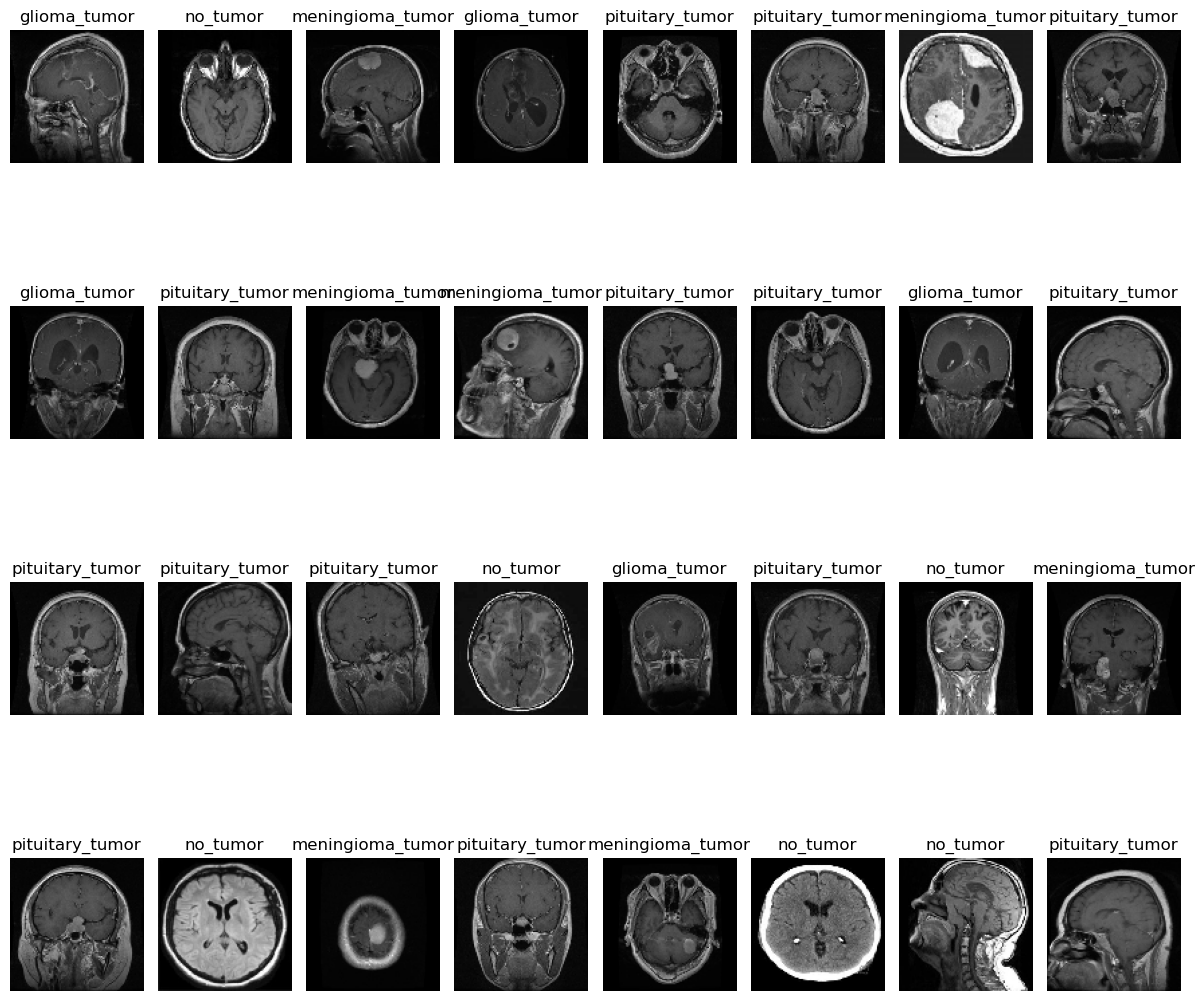

In [20]:
plt.figure(figsize = (12, 12))
class_dict = {0:'glioma_tumor', 1:'meningioma_tumor', 
              2:'no_tumor', 3:'pituitary_tumor'}
for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

### Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [22]:
pre_trained_model = MobileNet(weights = "imagenet", include_top = False,
                             input_shape=(img_width, img_height, 3)) # 이미지넷에서 학습한 가중치를 사용
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [23]:
model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D()) # flatten 대신
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [25]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = Adam(1e-5), metrics = ["acc"])

In [26]:
start_time = datetime.now()

result = model.fit(train_generator, epochs = 3, validation_data= test_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/3
90/90 [==============================] - 34s 322ms/step - loss: 2.4989 - acc: 0.2927 - val_loss: 1.5753 - val_acc: 0.2716
Epoch 2/3
90/90 [==============================] - 29s 318ms/step - loss: 2.1038 - acc: 0.3648 - val_loss: 1.4673 - val_acc: 0.3249
Epoch 3/3
90/90 [==============================] - 29s 320ms/step - loss: 1.8117 - acc: 0.4077 - val_loss: 1.3770 - val_acc: 0.3680
Elapsed Time :  0:01:31.367666


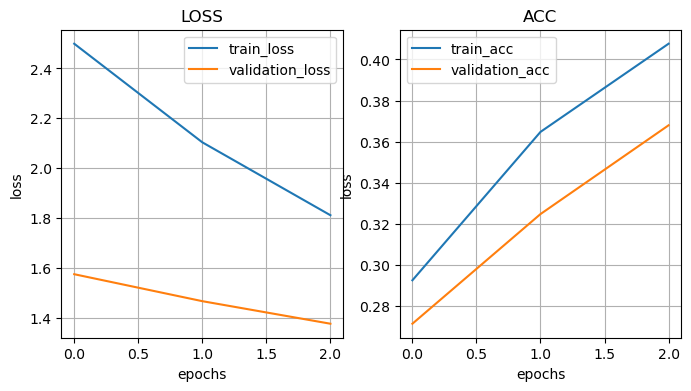

In [27]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label = "train_loss")
plt.plot(result.history["val_loss"], label = "validation_loss")
plt.legend(loc = "best")

plt.subplot(1, 2, 2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label = "train_acc")
plt.plot(result.history["val_acc"], label = "validation_acc")
plt.legend(loc = "best")

In [28]:
model.evaluate(test_generator)

13/13 [==============================] - 1s 77ms/step - loss: 1.3770 - acc: 0.3680


[1.3769625425338745, 0.36802029609680176]

# Project-2

### Testing 디렉토리의 모든 파일을 Training 동일 디렉토리로 move

In [29]:
test_label_name_list = os.listdir(test_data_root_dir)
print(test_label_name_list)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [31]:
for label_name in test_label_name_list:
    test_path = os.path.join(test_data_root_dir, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(train_data_root_dir, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num += 1

    print(str(move_num) + " is moved into " + label_name + \
         "(Testing => Training)")

100 is moved into glioma_tumor(Testing => Training)
115 is moved into meningioma_tumor(Testing => Training)
105 is moved into no_tumor(Testing => Training)
74 is moved into pituitary_tumor(Testing => Training)


### move 완료된 Training 전체 데이터 갯수 확인

In [32]:
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))

train label : glioma_tumor  => 926
train label : meningioma_tumor  => 937
train label : no_tumor  => 396
train label : pituitary_tumor  => 901


### Shuffle 후 다시 Testing으로 move

In [36]:
### move할 파일의 비율
move_ratio = 0.2

label_name_list = os.listdir(train_data_root_dir)

for label_name in label_name_list:
    src = os.path.join(train_data_root_dir, label_name)
    dst = os.path.join(test_data_root_dir, label_name)
    
    train_data_file_list = os.listdir(src)
    
    
    print("===========================================")
    print("total [%s] data file nums => [%s]"%(label_name, 
                                               len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")
    
    split_num = int(move_ratio*len(train_data_file_list))
    print("split nums = ", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num += 1
        
    print("total move num => ", move_num)
    print("=========================================")
    

total [glioma_tumor] data file nums => [926]
train data shuffle is done!
split nums =  185
total move num =>  185
total [meningioma_tumor] data file nums => [937]
train data shuffle is done!
split nums =  187
total move num =>  187
total [no_tumor] data file nums => [396]
train data shuffle is done!
split nums =  79
total move num =>  79
total [pituitary_tumor] data file nums => [901]
train data shuffle is done!
split nums =  180
total move num =>  180


In [37]:
### 훈련데이터 갯수 
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))


print("==========================================================")
### 테스트 데이터 갯수
test_label_name_list = os.listdir(test_data_root_dir)

for label_name in train_label_name_list:
    print("test label :", label_name, ' =>',
          len(os.listdir(os.path.join(test_data_root_dir, label_name))))

train label : glioma_tumor  => 741
train label : meningioma_tumor  => 750
train label : no_tumor  => 317
train label : pituitary_tumor  => 721
test label : glioma_tumor  => 185
test label : meningioma_tumor  => 187
test label : no_tumor  => 79
test label : pituitary_tumor  => 180


# 3. Project-3

- OpenCV를 이용하여 데이터를 로드하고 train data와 test data를 생성한 후에 TL을 이용해서 오버피팅이 최소가 될 수 있도록 90%이상 정확도를 달성하시오

In [44]:
### Testing 폴더 데이터를 Training폴더로 move
test_label_name_list = os.listdir(test_data_root_dir)


for label_name in test_label_name_list:
    test_path = os.path.join(test_data_root_dir, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(train_data_root_dir, label_name)
    
    move_num = 0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num += 1

    print(str(move_num) + " is moved into " + label_name + \
         "(Testing => Training)")

185 is moved into glioma_tumor(Testing => Training)
187 is moved into meningioma_tumor(Testing => Training)
79 is moved into no_tumor(Testing => Training)
180 is moved into pituitary_tumor(Testing => Training)


In [62]:
train_data_list = []
train_label_list = []

class_dict = {'glioma_tumor':0, 'meningioma_tumor':1, 
              'no_tumor':2, 'pituitary_tumor':3}

img_label_list = os.listdir(train_data_root_dir)

width_list = []
height_list = []

for img_label in img_label_list:
    file_path = os.path.join(train_data_root_dir, img_label)
    img_file_list = glob.glob(file_path + "/*.jpg")
    
    for img_file in img_file_list:
        src_img =cv2.imread(img_file, cv2.IMREAD_COLOR)
        
        width_list.append(src_img.shape[0])
        height_list.append(src_img.shape[1])
        
        src_img = cv2.resize(src_img, dsize = (img_width, img_height))
        src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
        
        train_data_list.append(src_img)
        train_label_list.append(float(class_dict[img_label]))
        
    width_arr = np.array(width_list)
    height_arr = np.array(height_list)

    print("===================================================")
    print("label = ", img_label)
    print("width average = ", np.round(np.average(width_arr)),
         "height average = ", np.round(np.average(height_arr)))
    print("width std = ", np.round(np.std(width_arr)),
         "height std = ", np.round(np.std(height_arr)))
    print("width max = ", np.round(np.max(width_arr)),
         "height max = ", np.round(np.max(height_arr)))
    print("width min = ", np.round(np.min(width_arr)),
         "height min = ", np.round(np.min(height_arr)))
    print("===================================================")

width_arr = None
height_arr = None
width_list = None
height_list = None


label =  glioma_tumor
width average =  503.0 height average =  501.0
width std =  48.0 height std =  52.0
width max =  665 height max =  640
width min =  167 height min =  175
label =  meningioma_tumor
width average =  485.0 height average =  481.0
width std =  86.0 height std =  92.0
width max =  1427 height max =  1275
width min =  167 height min =  174
label =  no_tumor
width average =  461.0 height average =  458.0
width std =  119.0 height std =  128.0
width max =  1446 height max =  1375
width min =  167 height min =  174
label =  pituitary_tumor
width average =  477.0 height average =  475.0
width std =  120.0 height std =  128.0
width max =  1446 height max =  1375
width min =  167 height min =  174


In [61]:
X_train = np.array(train_data_list)
y_train = np.array(train_label_list)

print(X_train.shape, y_train.shape)

(3160, 100, 100, 3) (3160,)


In [50]:
### move할 파일의 비율

move_ratio = 0.2

split_num = int(move_ratio * len(X_train))
print('split_num : ', split_num)

# shuffle
s = np.arange(len(X_train))
np.random.shuffle(s)

X_train = X_train[s]
y_train = y_train[s]

# test 데이터 생성
X_test = X_train[:split_num]
y_test = y_train[:split_num]

X_train = X_train[split_num:]
y_train = y_train[split_num:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 정규화
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

split_num :  505
(2023, 100, 100, 3) (2023,)
(505, 100, 100, 3) (505,)


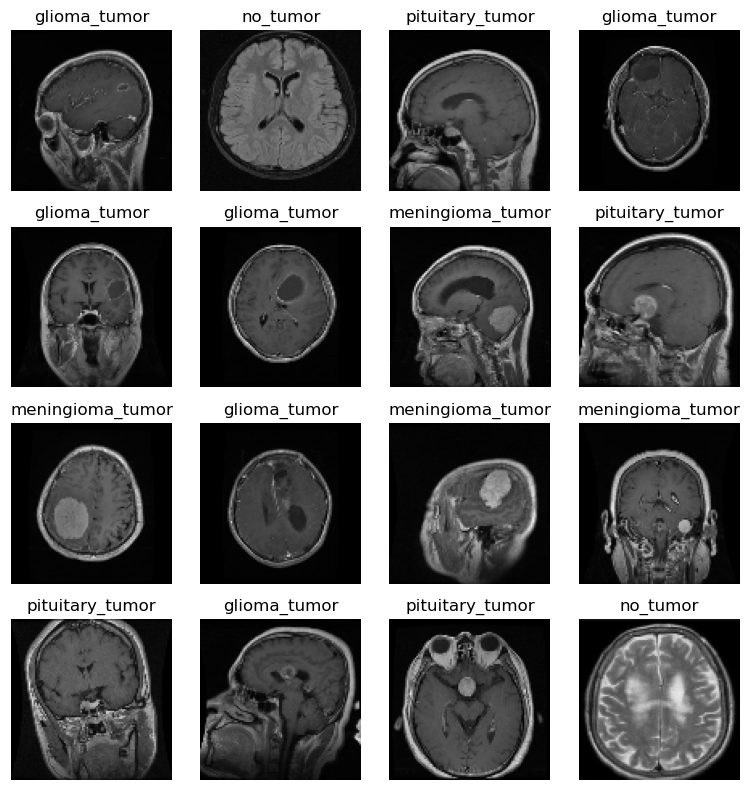

In [57]:
# 이미지 16개 확인
plt.figure(figsize = (8, 8))

class_dict = {0:'glioma_tumor', 1:'meningioma_tumor', 
              2:'no_tumor', 3:'pituitary_tumor'}

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.axis("off")
    plt.title(class_dict[y_train[i]])
    plt.imshow(X_train[i])
    plt.tight_layout()